**Data preperation**

In [1]:
!pip install pytorch-lightning==1.9.3 diffusers einops kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.

<ipython-input-2-8e1b666ea509>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = torch.FloatTensor(imageio.imread('Data/image_06740.jpg')/255)


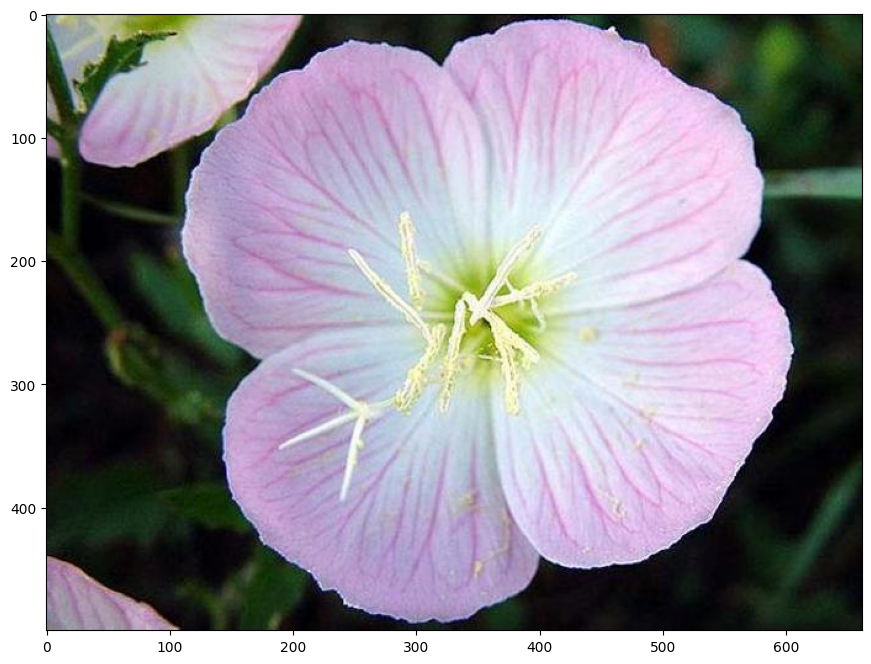

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio.v2 as imageio

mpl.rcParams['figure.figsize'] = (12, 8)

img = torch.FloatTensor(imageio.imread('Data/image_06740.jpg')/255)
plt.imshow(img)

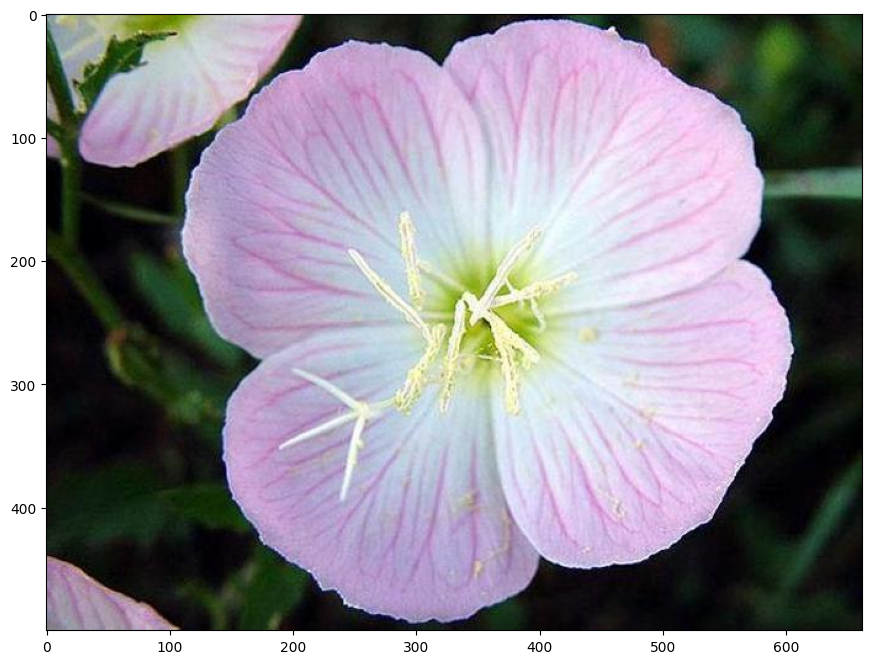

In [3]:
def input_T(input):
    # [0,1] -> [-1,+1]
    return 2*input-1

def output_T(input):
    # [-1,+1] -> [0,1]
    return (input+1)/2

def show(input):
    plt.imshow(output_T(input).clip(0,1))

img_=input_T(img)
show(img_)

**Defining a schedule**

In [4]:
num_timesteps=1000
betas=torch.linspace(1e-4,2e-2,num_timesteps)

alphas=1-betas
alphas_sqrt=alphas.sqrt()
alphas_cumprod=torch.cumprod(alphas,0)
alphas_cumprod_sqrt=alphas_cumprod.sqrt()

**Forward Process**


In [13]:
def forward_step(t, condition_img, return_noise=False):
    """
        forward step: t-1 -> t
    """
    assert t >= 0

    mean=alphas_sqrt[t]*condition_img
    std=betas[t].sqrt()

    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise

def forward_jump(t, condition_img, condition_idx=0, return_noise=False):
    """
        forward jump: 0 -> t
    """
    assert t >= 0

    mean=alphas_cumprod_sqrt[t]*condition_img
    std=(1-alphas_cumprod[t]).sqrt()

    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise

In [14]:
N=5 # number of computed states between x_0 and x_T
M=4 # number of samples taken from each distribution

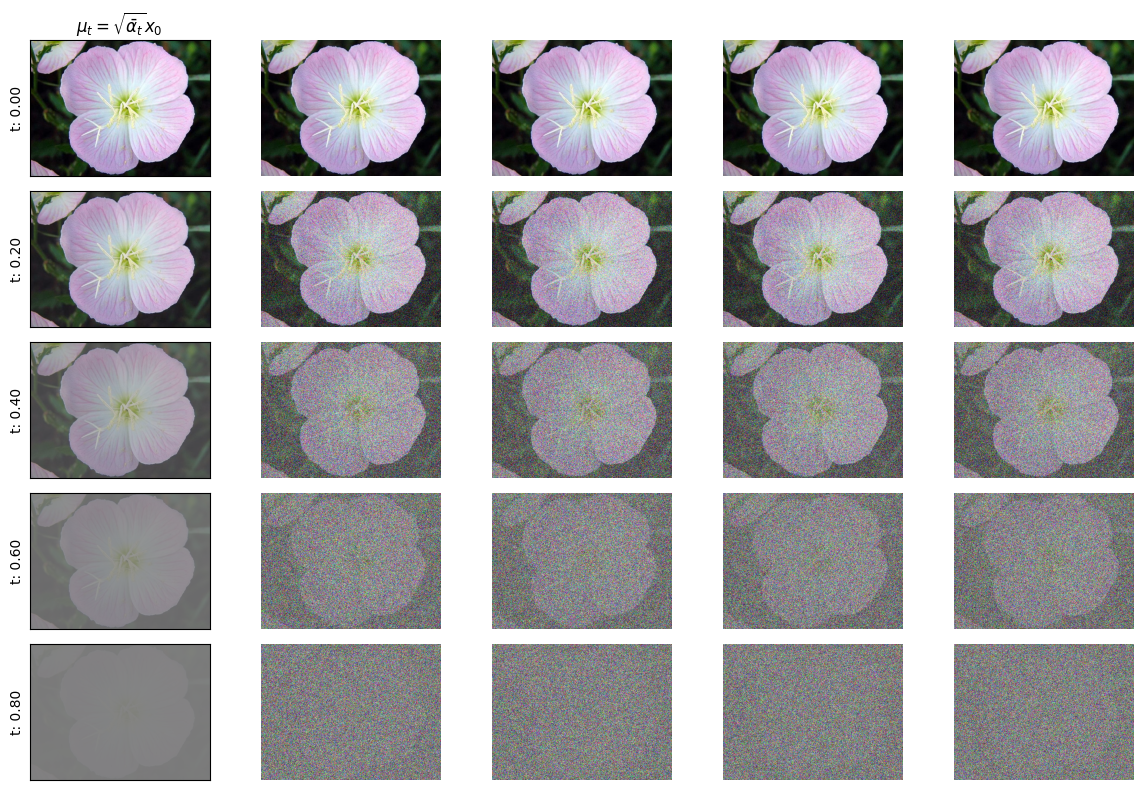

In [15]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))

    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_cumprod_sqrt[t_step]*img_)
    plt.title(r'$\mu_t=\sqrt{\bar{\alpha}_t}x_0$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])

    for sample in range(M):
        x_t=forward_jump(t_step,img_)

        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        show(x_t)
        plt.axis('off')

plt.tight_layout()

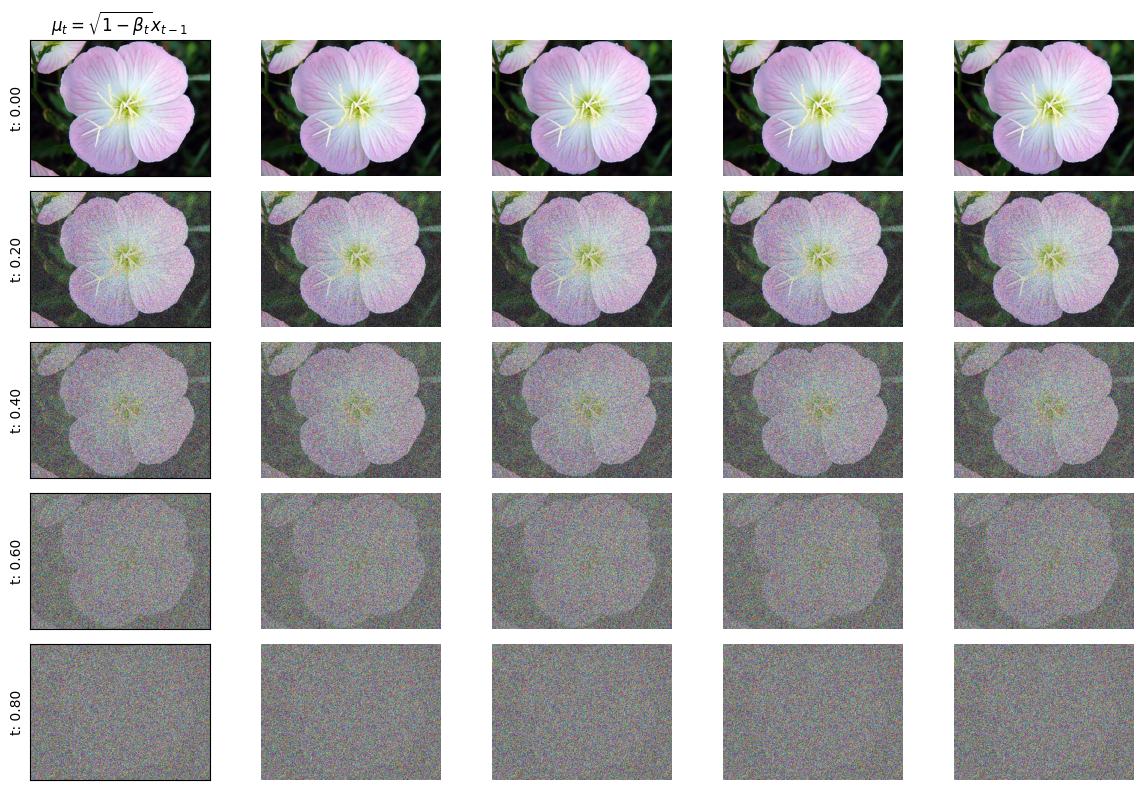

In [16]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))
    prev_img=forward_jump(max([0,t_step-1]),img_) # directly go to prev state

    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_sqrt[t_step]*prev_img)
    plt.title(r'$\mu_t=\sqrt{1-\beta_t}x_{t-1}$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])

    for sample in range(M):
        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        x_t=forward_step(t_step,prev_img)
        show(x_t)
        plt.axis('off')
plt.tight_layout()

**Reverse Process**

(-0.5, 661.5, 499.5, -0.5)

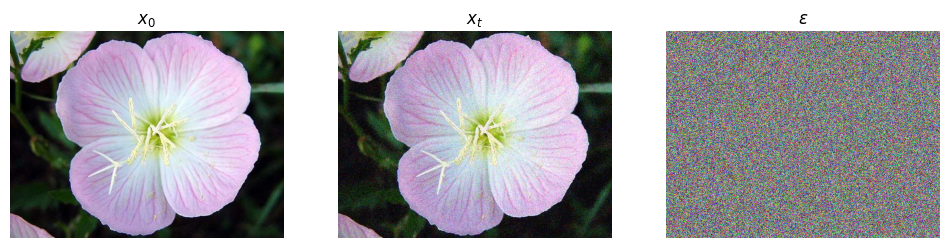

In [6]:
t_step=50

x_t,noise=forward_jump(t_step,img_,return_noise=True)

plt.subplot(1,3,1)
show(img_)
plt.title(r'$x_0$')
plt.axis('off')
plt.subplot(1,3,2)
show(x_t)
plt.title(r'$x_t$')
plt.axis('off')
plt.subplot(1,3,3)
show(noise)
plt.title(r'$\epsilon$')
plt.axis('off')

(-0.5, 661.5, 499.5, -0.5)

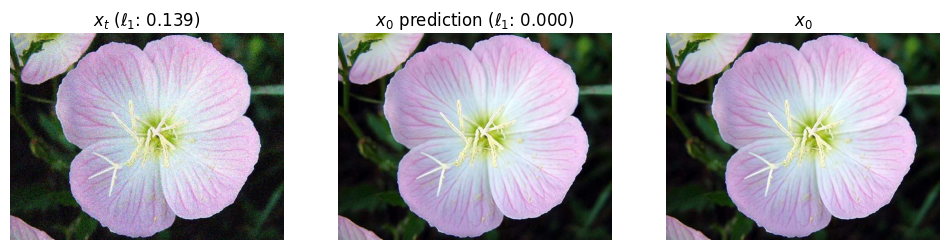

In [7]:
x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*noise)/(alphas_cumprod_sqrt[t_step])

plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$ ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.axis('off')
plt.subplot(1,3,2)
show(x_0_pred)
plt.title('$x_0$ prediction ($\ell_1$: {:.3f})'.format(F.l1_loss(x_0_pred,img_)))
plt.axis('off')
plt.subplot(1,3,3)
show(img_)
plt.title('$x_0$')
plt.axis('off')

In [8]:
# estimate mean
mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

# let's compare it to ground truth mean of the previous step (requires knowledge of x_0)
mean_gt=alphas_cumprod_sqrt[t_step-1]*img_

Text(0.5, 1.0, '$\\mu_{t-1}$  ($\\ell_1$: 0.010)')

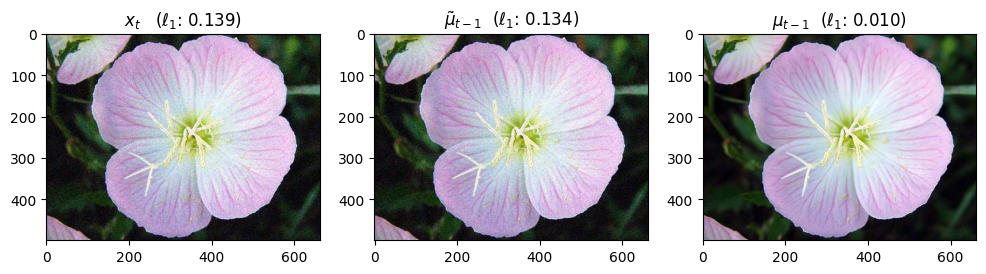

In [9]:
plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$   ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.subplot(1,3,2)
show(mean_pred)
plt.title(r'$\tilde{\mu}_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_pred,img_)))
plt.subplot(1,3,3)
show(mean_gt)
plt.title(r'$\mu_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_gt,img_)))

In [10]:
def reverse_step(epsilon, x_t, t_step, return_noise=False):

    # estimate x_0 based on epsilon
    x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*epsilon)/(alphas_cumprod_sqrt[t_step])
    if t_step==0:
        sample=x_0_pred
        noise=torch.zeros_like(x_0_pred)
    else:
        # estimate mean
        mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

        # compute variance
        beta_pred=betas[t_step].sqrt() if t_step != 0 else 0

        sample=mean_pred+beta_pred*torch.randn_like(x_t)
        # this noise is only computed for simulation purposes (since x_0_pred is not known normally)
        noise=(sample-x_0_pred*alphas_cumprod_sqrt[t_step-1])/(1-alphas_cumprod[t_step-1]).sqrt()
    if return_noise:
        return sample, noise
    else:
        return sample

In [11]:
x_t,noise=forward_jump(1000-1,img_,return_noise=True)

state_imgs=[x_t.numpy()]
for t_step in reversed(range(1000)):
    x_t,noise=reverse_step(noise,x_t,t_step,return_noise=True)

    if t_step % 200 == 0:
        state_imgs.append(x_t.numpy())

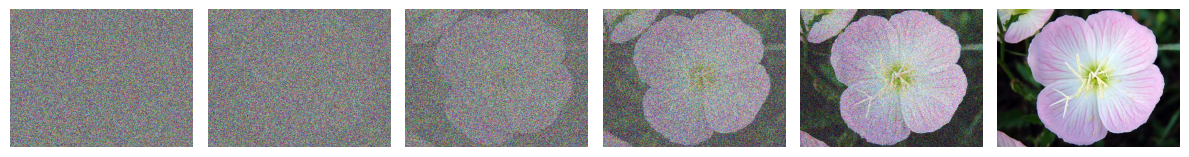

In [12]:
plt.figure()
for idx,state_img in enumerate(state_imgs):
    plt.subplot(1,len(state_imgs),idx+1)
    show(state_img.clip(-1,1))
    plt.axis('off')

plt.tight_layout()